# Data exploration, cleaning and loading

We load, explore and trasnform the data made available in this notebook for the task of classifiying articles based on their abstract among 4 classes (Computer Science, Mathematics, Physics and Statistics).

We start with importing the necessary basic libraries and prepare some functions that will be of use.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def get_clean_df(input_df):
    """Function that creates a pd.DataFrame with only the necessary information from raw data
    
    This function separates the features (abstract) and isolates the classes of interest by transforming the one-hot
    vectors into classes (0-3) for 'Computer Science','Mathematics', 'Physics', 'Statistics'
    """
    
    df_temp = pd.read_csv(input_df)
    #Separate features (abstract) and target (class)
    df_feature = df_temp['ABSTRACT']
    # transform one-hot vector to class
    df_target = df_temp[['Computer Science','Mathematics', 'Physics', 'Statistics']]
    df_target = np.array(df_target)
    df_target = pd.DataFrame([np.where(r==1)[0][0] for r in df_target])
    #final dataframe
    df_fin = pd.concat([df_feature, df_target], axis=1)
    return df_fin

def load_data(train_dir, test_dir):
    """Function that loads the data from the raw data file, calls the get_clean_data function
    and returns a data/label dataframe
    
    
    Takes training and test directories as input (must be strings) and saves the cleaned_data in an interim data file
    """
    
    train_df = get_clean_df(train_dir)
    train_df.columns = ['Data', 'Label']
    test_df = get_clean_df(test_dir)
    test_df.columns = ['Data', 'Label']
    train_df.to_csv('../data/interim/train_df.csv', index = False)
    print('Training data loaded')
    test_df.to_csv('../data/interim/test_df.csv', index = False)
    print('Test data loaded')

In [3]:
# Use the function to load the data
load_data("../data/raw/train_topics.csv", "../data/raw/test_topics.csv")

Training data loaded
Test data loaded


In [4]:
# Loading data from interim files

df_train = pd.read_csv("../data/interim/train_df.csv")
df_test = pd.read_csv("../data/interim/test_df.csv")
df_train.head()

,Data,Label
0,nanostructures with open shell transition meta...,2
1,stars are self-gravitating fluids inside which...,2
2,analyzing job hopping behavior was important c...,0
3,a need to reason about uncertainty inside larg...,3
4,"inside this work, the many-body potential of n...",2


In [5]:
# Dataset stats
print(df_train['Label'].value_counts())
print(df_test['Label'].value_counts())


0    3366
2    2972
1    1570
3    1538
Name: Label, dtype: int64
0    840
2    785
3    376
1    353
Name: Label, dtype: int64


We notice that the classes are unbalanced. For the purposes of exploration, we will create 2 datasets: one that will keep the samples as is and another where we will undersample in order to avoid sample distribution bias when training our models.

In [6]:
# Undersampling train to create a more balanced dataset
categories = sorted(df_train['Label'].unique())
counts = df_train.groupby(["Label"]).size().reset_index(name='counts')
min_size_category = counts["counts"].min()

train_balanced = pd.DataFrame()
for cat in categories:
    data_category = df_train[df_train["Label"] == cat]
    sample_to_concat = data_category.sample(min_size_category)
    train_balanced = pd.concat([train_balanced, sample_to_concat], axis=0)

undersample_train = train_balanced.sample(frac=1).reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [7]:
undersample_train["Label"].value_counts()

2    1538
0    1538
1    1538
3    1538
Name: Label, dtype: int64

In [8]:
# Undersampling test to create a more balanced dataset
categories = sorted(df_test['Label'].unique())
counts = df_test.groupby(["Label"]).size().reset_index(name='counts')
min_size_category = counts["counts"].min()

test_balanced = pd.DataFrame()
for cat in categories:
    data_category = df_test[df_test["Label"] == cat]
    sample_to_concat = data_category.sample(min_size_category)
    test_balanced = pd.concat([test_balanced, sample_to_concat], axis=0)

undersample_test = test_balanced.sample(frac=1).reset_index(drop=True)

In [9]:
undersample_test["Label"].value_counts()

2    353
3    353
0    353
1    353
Name: Label, dtype: int64

## Data exploration

For the purpose of exploring the data, we will try to get insights from the distribution of raw data.

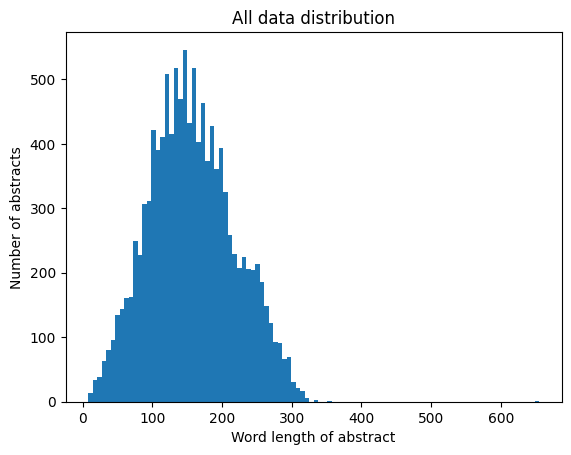

In [10]:
# Plot distribution of abstracts by word length
df_expl = pd.concat([df_train, df_test], ignore_index = True)
plt.hist([len(t.split()) for t in df_expl['Data']], 100)
plt.xlabel('Word length of abstract')
plt.ylabel('Number of abstracts')
plt.title('All data distribution')
plt.rcParams["figure.figsize"] = (18.5,10.5)
plt.show()

The distribution seems fairly gaussian with an exception at more than 600 words. This is to be expected from journal requirements that demand abstracts to be 150-300 words usually.

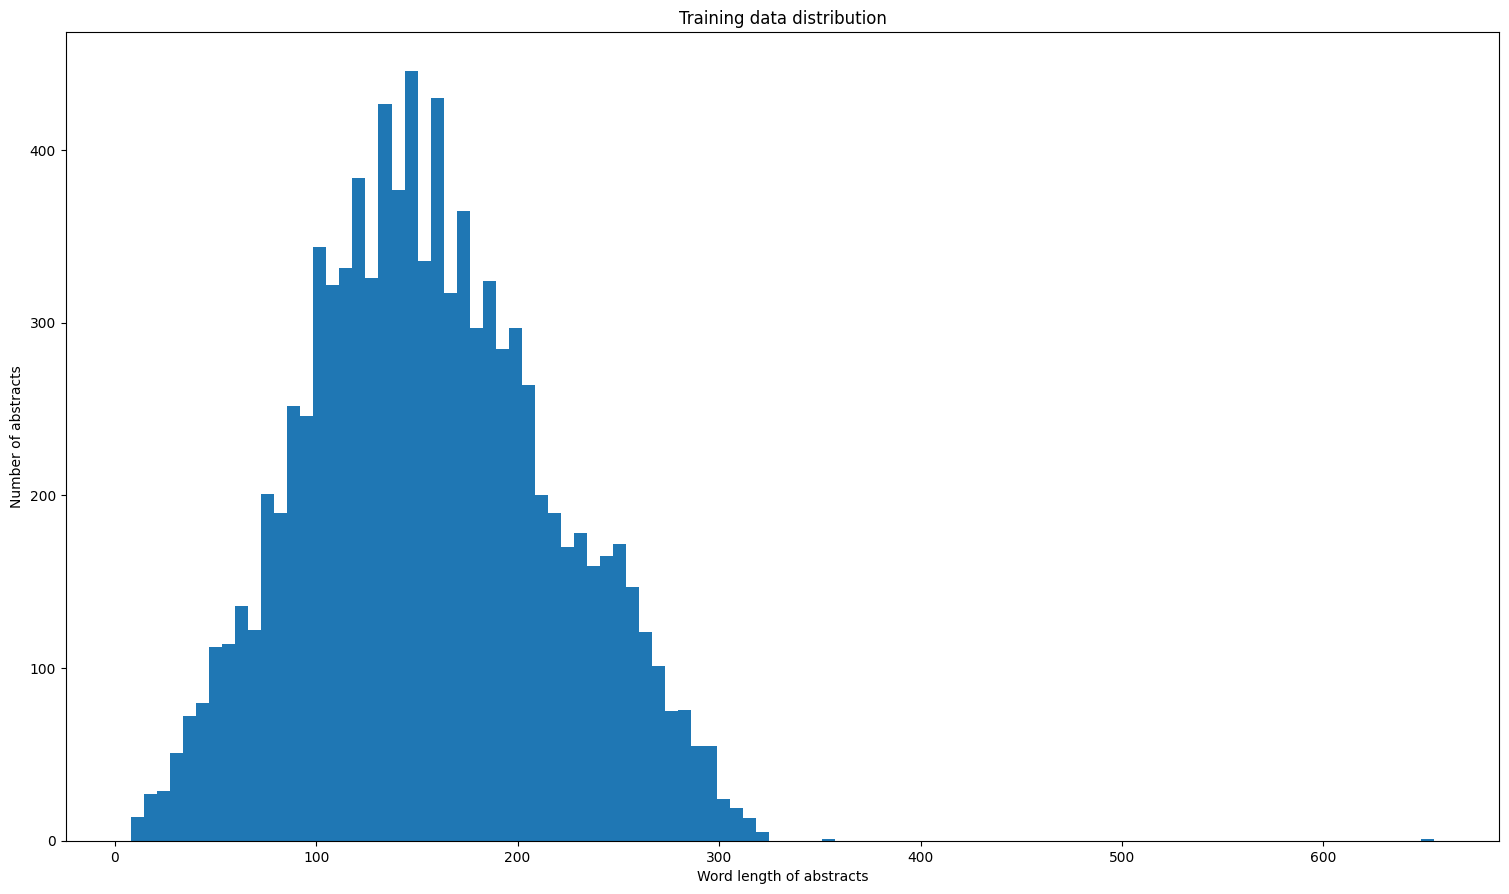

In [11]:
# Plot distribution of Abstract by word length
plt.hist([len(t.split()) for t in df_train['Data']], 100)
plt.xlabel('Word length of abstracts')
plt.ylabel('Number of abstracts')
plt.rcParams["figure.figsize"] = (18.5,10.5)
plt.title('Training data distribution')
plt.show()

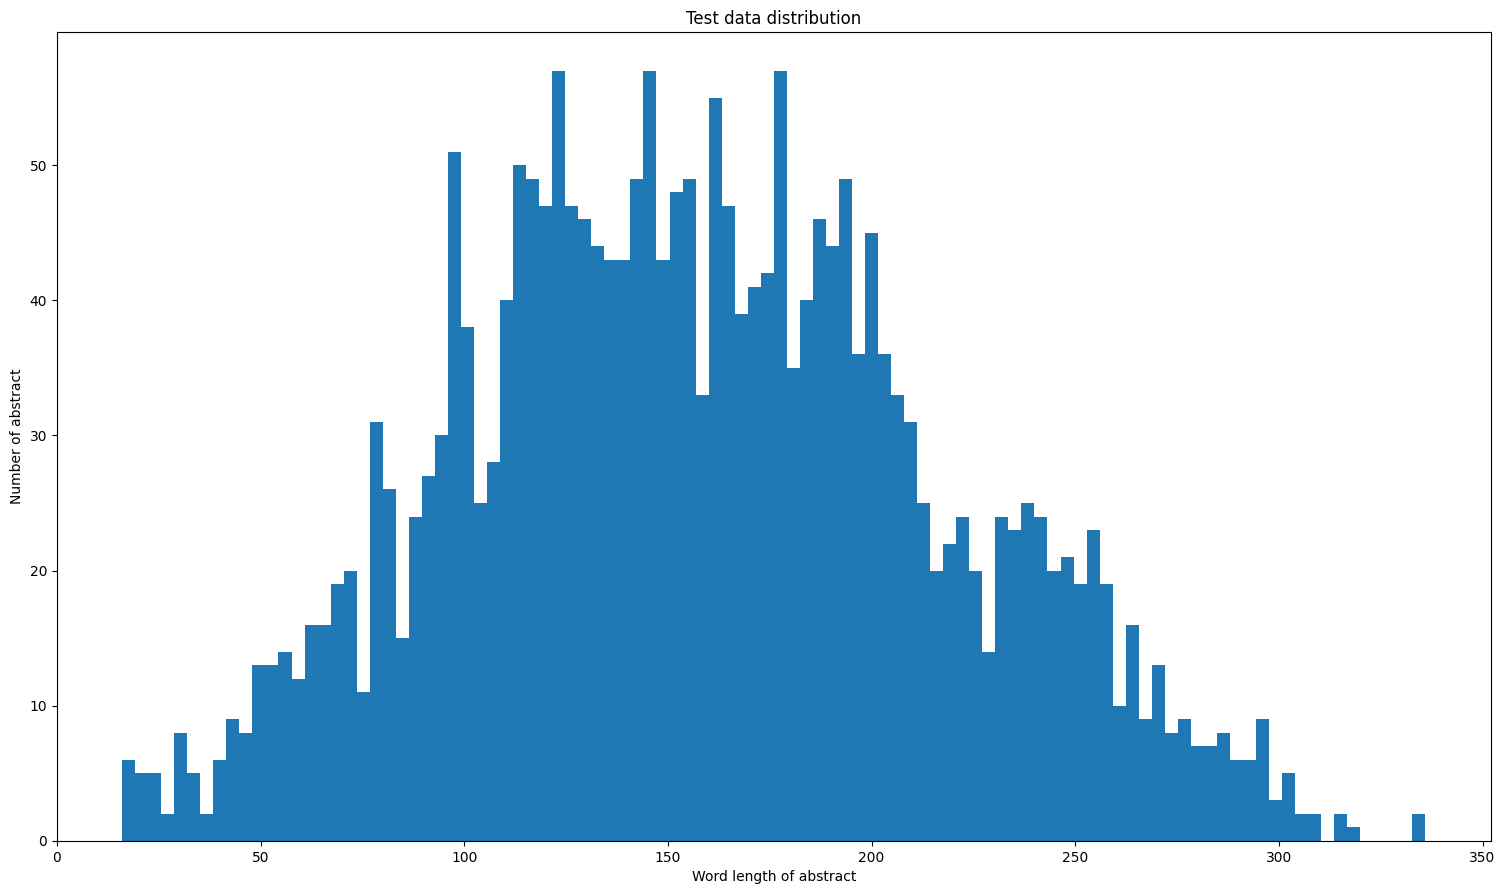

In [12]:
# Plot distribution of abstracts by word length
plt.hist([len(t.split()) for t in df_test['Data']], 100)
plt.xlabel('Word length of abstract')
plt.ylabel('Number of abstract')
plt.rcParams["figure.figsize"] = (18.5,10.5)
plt.title('Test data distribution')
plt.show()

Both training and test data distributions seem to follow mostly gaussian distributions and we can expect to not be hindered in our choice of Machine Learning model for this classification task.

## Text normalization

We now move to the normalization of the abstracts which entails the removal of special characters, passing all text in lower case, lemmatizing and removing stopwords.

After loading the necessary libraries, we implement functions to perform text normalization and apply them to all datasets in the interim files

In [13]:
# Imports for text normalization
import spacy
import nltk
nltk.download('stopwords')
import re
from nltk.tokenize.toktok import ToktokTokenizer
# from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Text tokenizer
tokenizer = ToktokTokenizer()
stopwords = nltk.corpus.stopwords.words('english')

In [15]:
nlp = spacy.load("en_core_web_sm")

In [16]:
# remove special characters
def remove_special_chara(text):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

# lower case
def lower_case(text):
    text = text.lower()
    return text

# lemmatization
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

# # stem word endings
# # unexpected results
# def stemmer(text):
#     ps = nltk.porter.PorterStemmer()
#     text = ' '.join([ps.stem(word) for word in text.split()])
#     return(text)

# remove stop words
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [17]:
def text_normer(text):
    text = text.apply(remove_special_chara)
    text = text.apply(lower_case)
#     unexpected results
#     text = text.apply(stemmer)
    text = text.apply(lemmatize_text)
    text = text.apply(remove_stopwords)
    return text

The following lines can be time consuming on local setup (400seconnds on current machine). This step is the lengthiest of this notebook. We take note hear that this will be one of the bottlenecks when implementing this model in an automated and updated ML system.

In [18]:
tic = time.time()
normalized_train = text_normer(df_train['Data'])
print(f"Time to normalize training data: {time.time() - tic:.2f} s")

Time to normalize training data: 258.25 s


In [19]:
tic = time.time()
normalized_test = text_normer(df_test['Data'])
print(f"Time to normalize test data: {time.time() - tic:.2f} s")

Time to normalize test data: 70.66 s


In [20]:
tic = time.time()
under_normalized_train = text_normer(undersample_train['Data'])
print(f"Time to normalize undersampled training data: {time.time() - tic:.2f} s")

Time to normalize undersampled training data: 170.63 s


In [21]:
tic = time.time()
under_normalized_test = text_normer(undersample_test['Data'])
print(f"Time to normalize undersampled test data: {time.time() - tic:.2f} s")

Time to normalize undersampled test data: 38.45 s


We collect all the data and save it under the 'processed' file

In [22]:
# Collect data in appropriate dataframes and save
# training data
df_norm_train = pd.DataFrame().assign(Data = normalized_train, Label = df_train['Label'])
# test data
df_norm_test = pd.DataFrame().assign(Data = normalized_test, Label = df_test['Label'])
# Undersampled train
df_under_train = pd.DataFrame().assign(Data = under_normalized_train, Label = undersample_train['Label'])
# Undersampled test
df_under_test = pd.DataFrame().assign(Data = under_normalized_test, Label = undersample_test['Label'])


# save everything as CSV
df_norm_train.to_csv("../data/processed/normalized_train.csv", index = False)
df_norm_test.to_csv('../data/processed/normalized_test.csv', index = False)
df_under_train.to_csv('../data/processed/undersampled_train.csv', index = False)
df_under_test.to_csv('../data/processed/undersampled_test.csv', index = False)

For the purpose of further exploration, the output of the text_normer function is shown here without and with the stemmer function.

In [23]:
# output without stemmer

# 'nanostructure open shell transition metal molecular constituent host often strong electronic correlation highly sensitive atomistic material detail tutorial review discuss method development application theoretical approach consider realistic description electronic magnetic property nanostructure correlated electron first implementation flexible interface density functional theory variant dynamical mean field theory dmft highly suitable consider simulation complex correlate structure explain illustrate dmft side interface largely base recent development quantum monte carlo exact diagonalization technique allow consider efficient description general four fermion coulomb interaction reduce symmetry spinorbit coupling explain example cr 001 surface magnetic adatom molecular system show interplay hubbard u hund j determine charge spin fluctuation interaction drive different sort correlation effect inside nanosystem nonlocal interaction correlation present particular challenge consider theory low dimensional system present method development address two challenge ie advancement dynamical vertex approximation combination constrain random phase approximation continuum medium theory demonstrate nonlocal interaction correlation phenomenon control dimensionality also couple environment typically important consider determine physics nanosystem'

In [24]:
# output with stemmer
# 'nanostructur open shell transit metal molecular constitu host often strong electron correl highli sensit atomist materi detail thi tutori review discuss method develop applic theoret approach consid realist descript electron magnet properti nanostructur correl electron first implement flexibl interfac densiti function theori variant dynam mean field theori dmft highli suitabl consid simul complex correl structur wa explain illustr dmft side thi interfac wa larg base recent develop quantum mont carlo exact diagon techniqu allow consid effici descript gener four fermion coulomb interact reduc symmetri spinorbit coupl explain exampl cr 001 surfac magnet adatom molecular system wa show interplay hubbard u hund j determin charg spin fluctuat interact drive differ sort correl effect insid nanosystem nonloc interact correl present particular challeng consid theori low dimension system present method develop address two challeng ie advanc dynam vertex approxim combin constrain random phase approxim continuum medium theori demonstr nonloc interact correl phenomenon control onli dimension also coupl environ wa typic import consid determin physic nanosystem'